In [1]:
from random import random
import numpy as np
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
import heapq
import seaborn as sns
import pandas as pd
import itertools
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep")
np.random.seed(44)

In [2]:
def sim_clock(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_clock = [tg.sim_clock(int(_c), trace, raw=True) for _c in c]
    return c, hr_clock

def sim_ran_clock(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_ran_clock = [tg.sim_ran_clock(int(_c), trace, raw=True, K=cnt) for _c in c]
    return c, hr_ran_clock

def sim_fifo_m(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_fifo_m = [tg.sim_fifo_m([int(s)//2, int(s) - int(s)//2], trace, raw=True) for s in c] 
    return c, hr_fifo_m

def sim_rand_m(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_rand_m = [tg.sim_rand_m([int(s)//2, int(s) - int(s)//2], trace, raw=True) for s in c] 
    return c, hr_rand_m

def sim_sieve(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_sieve = [tg.sim_sieve(int(_c), trace, raw=True) for _c in c]
    return c, hr_sieve

def sim_lru(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_lru = [tg.sim_lru(int(_c), trace, raw=True) for _c in c]
    return c, hr_lru

def sim_fifo(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_fifo = [tg.sim_fifo(int(_c), trace, raw=True) for _c in c]
    return c, hr_fifo

def gen_from_zipf(M, n, a):
    p = 1.0 / np.power(np.arange(1, M + 1), a)
    p = p / p.sum()
    return p, np.random.choice(M, size=n, p=p)

def gen_ph(m, theta, length):
    p = 1.0 / np.power(np.arange(1, m + 1), theta)
    p = p / p.sum()
    cp = np.cumsum(p)
    t = p.copy()
    phases = np.searchsorted(cp, np.random.random(m), side="right")
    next_times = np.random.exponential(1.0 / t[phases])
    heap = [(next_times[i], i) for i in range(m)]
    heapq.heapify(heap) 
    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = np.searchsorted(cp, np.random.random(), side="right")
        next_time = ctime + np.random.exponential(1.0 / t[phases[item]])
        heapq.heappush(heap, (next_time, item))
    return trace

# def gen_from_iad(f, M, n):
#     # f(): returns a positive integer IAD sample
#     h = [(f(), i) for i in range(M)]
#     heapq.heapify(h)
#     trace = []
#     for _ in range(n):
#         t, addr = heapq.heappop(h)
#         trace.append(addr)
#         heapq.heappush(h, (t + f(), addr))
#     return np.array(trace, dtype=np.int32)

def gen_ph_2class(n, theta, length, mu_ratio=10.0):
    p = 1.0 / np.power(np.arange(1, n + 1), theta)
    p /= p.sum()

    alpha0 = 0.5
    alpha = np.array([0.5, 0.5], dtype=float)

    mu2 = (1.0 / mu_ratio + 1.0) / 2.0
    mu1 = mu_ratio * mu2
    T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=float)

    t = -T.sum(axis=1)
    B = T + t[:, None] * alpha[None, :]
    scale = np.max(-np.diag(B))
    P = B / scale + np.eye(2)
    a, b = P[0, 1], P[1, 0]
    beta = np.array([0.5, 0.5], dtype=float) if a + b == 0 else np.array([b / (a + b), a / (a + b)], dtype=float)
    arate = beta.dot(t)
    t /= arate

    phases = (np.random.random(n) >= alpha0).astype(np.int8)
    rates = t[phases] * p
    next_times = np.random.exponential(1.0 / rates)
    heap = [(next_times[i], i) for i in range(n)]
    heapq.heapify(heap)

    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = 0 if np.random.random() < alpha0 else 1
        rate = t[phases[item]] * p[item]
        heapq.heappush(heap, (ctime + np.random.exponential(1.0 / rate), item))
    return trace

In [3]:
lmb, irm2 = gen_from_zipf(120, 10000000, 0.8)
he2 = gen_ph(120, 0.8, 10000000)
ph2 = gen_ph_2class(120, 0.8, 10000000, mu_ratio=10.0)

In [4]:
np.savetxt('zipf_120_08_trace.txt', irm2, fmt='%d')
np.savetxt('he_120_08_trace.txt', he2, fmt='%d')
np.savetxt('ph_120_08_trace.txt', ph2, fmt='%d')

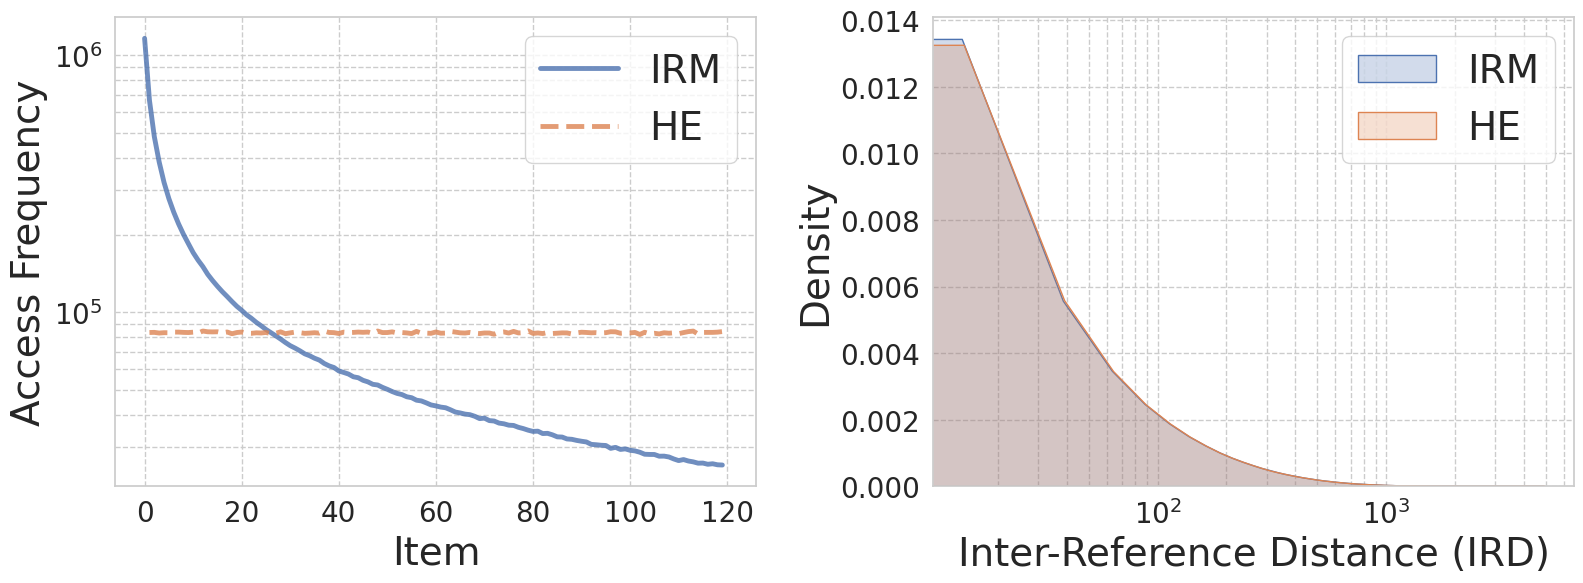

In [6]:
sns.set_theme(style="whitegrid", palette="deep")
palette = sns.color_palette("deep")

u1, c1 = np.unique(irm2, return_counts=True)
u2, c2 = np.unique(ph2, return_counts=True)

iads1 = tg.iad(irm2)
iads1 = iads1[iads1 > 0]
iads2 = tg.iad(ph2)
iads2 = iads2[iads2 > 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Access frequency
ax1.semilogy(u1, c1, label='IRM', lw=3.5, color=palette[0], alpha=0.8)
ax1.semilogy(u2, c2, label='HE', lw=3.5, color=palette[1], alpha=0.8, linestyle='--')
ax1.tick_params(axis='both', labelsize=20)
ax1.set_xlabel('Item', fontsize=28)
ax1.set_ylabel('Access Frequency', fontsize=28)
ax1.legend(fontsize=28)
ax1.grid(True, which="both", ls="--")

# IRD KDE
sns.kdeplot(iads1, bw_adjust=0.5, label='IRM', fill=True, ax=ax2, color=palette[0])
sns.kdeplot(iads2, bw_adjust=0.5, label='HE', fill=True, ax=ax2, color=palette[1])
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax2.xaxis.get_major_formatter().set_scientific(True)
ax2.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax2.tick_params(axis='both', labelsize=20)
ax2.set_xscale('log')
ax2.set_xlabel('Inter-Reference Distance (IRD)', fontsize=28)
ax2.set_ylabel('Density', fontsize=28)
ax2.legend(fontsize=28)
ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.savefig('freqs_irds.pdf', bbox_inches='tight', format='pdf')
plt.show()


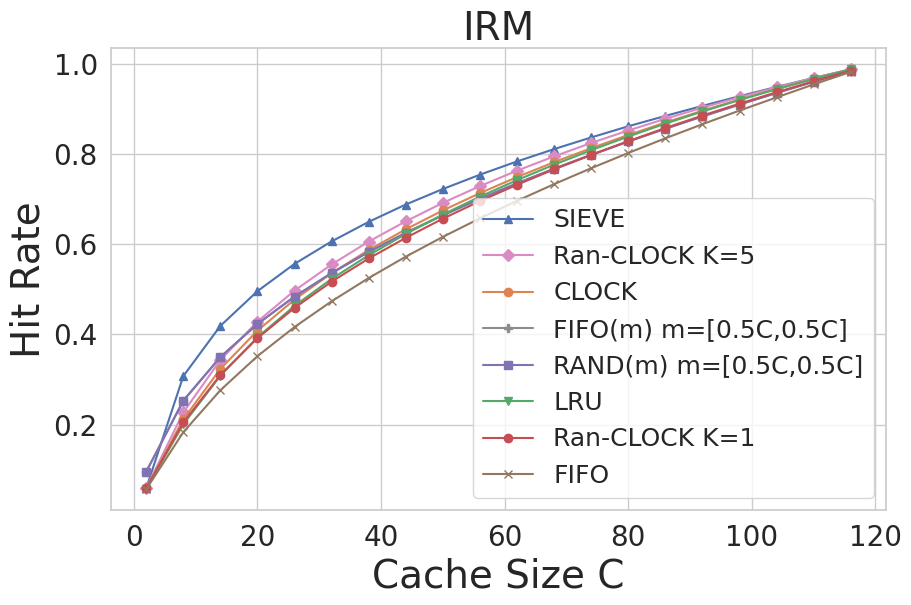

IRM Average Hit Rates:
SIEVE: 0.7084600400000001
Ran-CLOCK K=5: 0.681346855
CLOCK: 0.6694223849999998
RAND(m) m=[0.5C,0.5C]: 0.6683419799999999
FIFO(m) m=[0.5C,0.5C]: 0.66832016
LRU: 0.662796135
Ran-CLOCK K=1: 0.656583095
FIFO: 0.6291371400000001


In [ ]:
c1, hr_ran_clock1 = sim_ran_clock(irm2, cnt=1)
c5, hr_ran_clock5 = sim_ran_clock(irm2, cnt=5)
cl, hr_fifo_m = sim_fifo_m(irm2)
cr, hr_rand_m = sim_rand_m(irm2)
cc, hr_clock = sim_clock(irm2)
cs, hr_sieve = sim_sieve(irm2)
cl, hr_lru = sim_lru(irm2)
cf, hr_fifo = sim_fifo(irm2)

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.xaxis.get_major_formatter().set_scientific(True)
# ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.yaxis.get_major_formatter().set_scientific(True)
# ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
plt.plot(cs, hr_sieve, color=palette[0], marker='^', label='SIEVE')
plt.plot(c5, hr_ran_clock5, color=palette[6], marker='D', label='Ran-CLOCK K=5')
plt.plot(cc, hr_clock, color=palette[1], marker='o', label='CLOCK')
plt.plot(cl, hr_fifo_m, color=palette[7], marker='P', label='FIFO(m) m=[0.5C,0.5C]')
plt.plot(cr, hr_rand_m, color=palette[4], marker='s', label='RAND(m) m=[0.5C,0.5C]')
plt.plot(cl, hr_lru, color=palette[2], marker='v', label='LRU')
plt.plot(c1, hr_ran_clock1, color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(cf, hr_fifo, color=palette[5], marker='x', label='FIFO')
plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=18)
plt.title('IRM', fontsize=28)
plt.grid(True)
plt.savefig('mrcs_irm.pdf', bbox_inches='tight', format='pdf')
plt.show()

avgs = [('SIEVE', np.mean(np.array(hr_sieve))),
        ('CLOCK', np.mean(np.array(hr_clock))),
        ('LRU', np.mean(np.array(hr_lru))),
        ('Ran-CLOCK K=1', np.mean(np.array(hr_ran_clock1))),
        ('Ran-CLOCK K=5', np.mean(np.array(hr_ran_clock5))),
        ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hr_rand_m))),
        ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hr_fifo_m))),
        ('FIFO', np.mean(np.array(hr_fifo)))]
avgs.sort(key=lambda x: x[1], reverse=True)
print("IRM Average Hit Rates:")
for name, avg in avgs:
    print(f"{name}: {avg}")

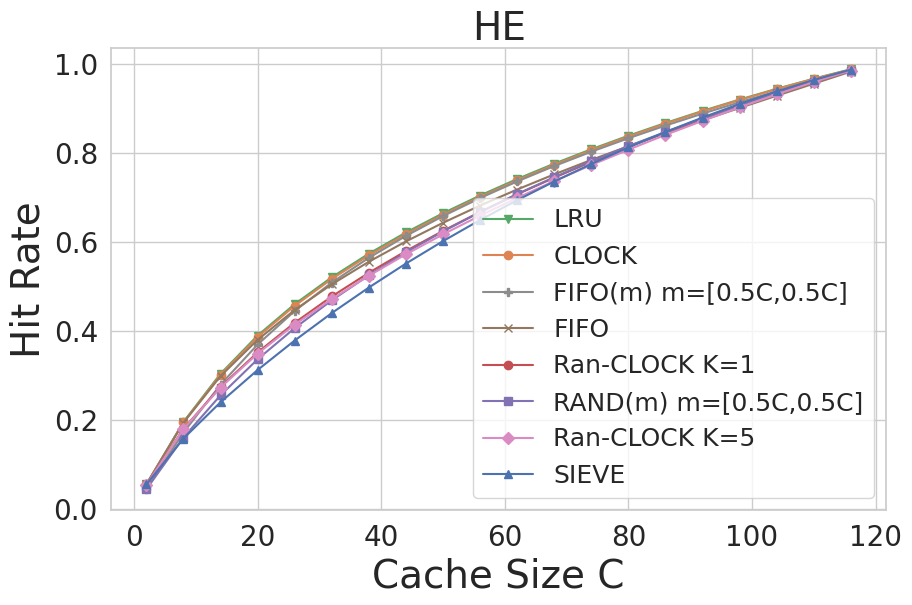

HE Average Hit Rates:
LRU: 0.6613075150000001
CLOCK: 0.65915747
FIFO(m) m=[0.5C,0.5C]: 0.65189007
FIFO: 0.64545666
Ran-CLOCK K=1: 0.6351255450000001
RAND(m) m=[0.5C,0.5C]: 0.6308334299999998
Ran-CLOCK K=5: 0.6307515749999999
SIEVE: 0.621065105


In [9]:
cph1, hr_ph_ran_clock1 = sim_ran_clock(ph2, cnt=1)
cph5, hr_ph_ran_clock5 = sim_ran_clock(ph2, cnt=5)
cl_ph, hr_ph_fifo_m = sim_fifo_m(ph2)
cr_ph, hr_ph_rand_m = sim_rand_m(ph2)
cc_ph, hr_ph_clock = sim_clock(ph2)
cs_ph, hr_ph_sieve = sim_sieve(ph2)
cl_ph, hr_ph_lru = sim_lru(ph2)
cf_ph, hr_ph_fifo = sim_fifo(ph2)

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
plt.plot(cl_ph, hr_ph_lru, color=palette[2], marker='v', label='LRU')
plt.plot(cc_ph, hr_ph_clock, color=palette[1], marker='o', label='CLOCK')
plt.plot(cl_ph, hr_ph_fifo_m, color=palette[7], marker='P', label='FIFO(m) m=[0.5C,0.5C]')
plt.plot(cf_ph, hr_ph_fifo, color=palette[5], marker='x', label='FIFO')
plt.plot(cph1, hr_ph_ran_clock1, color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(cr_ph, hr_ph_rand_m, color=palette[4], marker='s', label='RAND(m) m=[0.5C,0.5C]')
plt.plot(cph5, hr_ph_ran_clock5, color=palette[6], marker='D', label='Ran-CLOCK K=5')
plt.plot(cs_ph, hr_ph_sieve, color=palette[0], marker='^', label='SIEVE')

plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=18)
plt.title('HE', fontsize=28)
plt.grid(True)
plt.savefig('mrcs_he.pdf', bbox_inches='tight', format='pdf')
plt.show()

avgs2 = [('SIEVE', np.mean(np.array(hr_ph_sieve))),
         ('CLOCK', np.mean(np.array(hr_ph_clock))),
         ('LRU', np.mean(np.array(hr_ph_lru))),
         ('Ran-CLOCK K=1', np.mean(np.array(hr_ph_ran_clock1))),
         ('Ran-CLOCK K=5', np.mean(np.array(hr_ph_ran_clock5))),
         ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_rand_m))),
         ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_fifo_m))),
         ('FIFO', np.mean(np.array(hr_ph_fifo)))]
avgs2.sort(key=lambda x: x[1], reverse=True)
print("HE Average Hit Rates:")
for name, avg in avgs2:
    print(f"{name}: {avg}")

In [10]:
assert cph1.all() == cph5.all() == cl_ph.all() == cr_ph.all() == cc_ph.all() == cs_ph.all() == cf_ph.all() == c1.all() == c5.all() == cl.all() == cr.all() == cc.all() == cs.all() == cf.all()

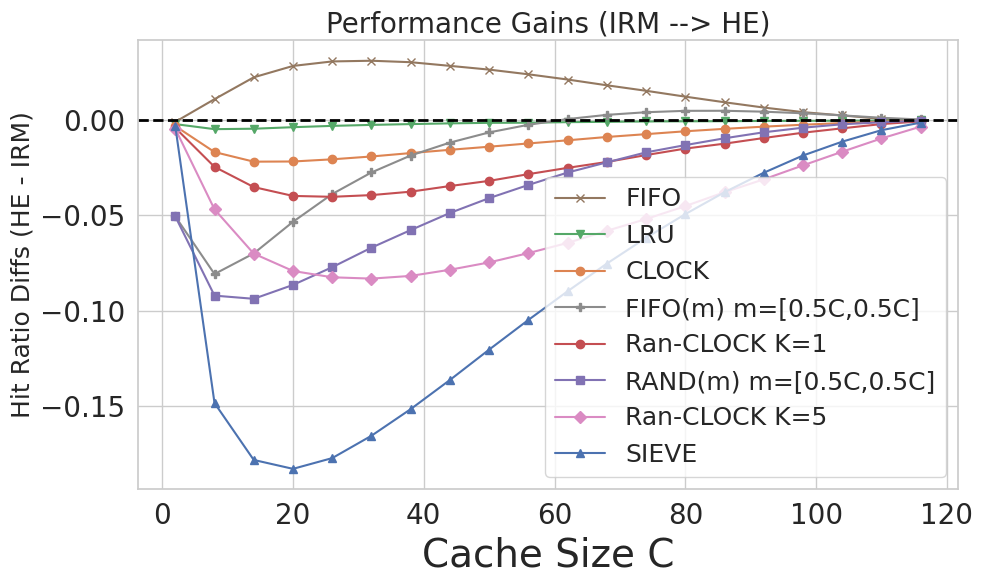

In [11]:
policies = ["FIFO", "LRU", "CLOCK", "FIFO(m) m=[0.5C,0.5C]", "Ran-CLOCK K=1", "RAND(m) m=[0.5C,0.5C]", "Ran-CLOCK K=5", "SIEVE"]
irm_hr = [hr_fifo, hr_lru, hr_clock, hr_fifo_m, hr_ran_clock1, hr_rand_m, hr_ran_clock5, hr_sieve]
he_hr  = [hr_ph_fifo, hr_ph_lru, hr_ph_clock, hr_ph_fifo_m, hr_ph_ran_clock1, hr_ph_rand_m, hr_ph_ran_clock5, hr_ph_sieve]
colors = [palette[5], palette[2], palette[1], palette[7], palette[3], palette[4], palette[6], palette[0]]
markers = ['x', 'v', 'o', 'P', 'o', 's', 'D', '^']

c = cph1
rows = []
for name, irm, he in zip(policies, irm_hr, he_hr):
    irm = np.array(irm)
    he  = np.array(he)
    delta = he - irm
    for C, d in zip(c, delta):
        rows.append({"C": C, "policy": name, "delta_hr": d})

df_delta = pd.DataFrame(rows)
plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
for name, color, marker in zip(policies, colors, markers):
    sub = df_delta[df_delta["policy"] == name]
    plt.plot(sub["C"], sub["delta_hr"], marker=marker, label=name, color=color)
plt.axhline(0, color='black', linewidth=2, linestyle='--')
plt.xlabel("Cache Size C", fontsize=28)
plt.ylabel("Hit Ratio Diffs (HE - IRM)", fontsize=18)
plt.title("Performance Gains (IRM --> HE)", fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.savefig('mrcs_delta.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [12]:
avgs3 = [('SIEVE', np.mean(np.array(hr_ph_sieve) - np.array(hr_sieve))),
         ('CLOCK', np.mean(np.array(hr_ph_clock) - np.array(hr_clock))),
         ('LRU', np.mean(np.array(hr_ph_lru) - np.array(hr_lru))),
         ('Ran-CLOCK K=1', np.mean(np.array(hr_ph_ran_clock1) - np.array(hr_ran_clock1))),
         ('Ran-CLOCK K=5', np.mean(np.array(hr_ph_ran_clock5) - np.array(hr_ran_clock5))),
         ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_rand_m) - np.array(hr_rand_m))),
         ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_fifo_m) - np.array(hr_fifo_m))),
         ('FIFO', np.mean(np.array(hr_ph_fifo) - np.array(hr_fifo)))]
avgs3.sort(key=lambda x: x[1], reverse=True)
print("Performance gains:")
for name, avg in avgs3:
    print(f"{name}: {avg}")

Performance gains:
FIFO: 0.016319519999999987
LRU: -0.0014886200000000071
CLOCK: -0.010264914999999996
FIFO(m) m=[0.5C,0.5C]: -0.01643009
Ran-CLOCK K=1: -0.021457549999999992
RAND(m) m=[0.5C,0.5C]: -0.03750855
Ran-CLOCK K=5: -0.05059528000000002
SIEVE: -0.08739493499999999


In [50]:
# verify simulation for fifo(m) matches paper
trace = gen_from_zipf(300, 20000000, 0.8)[1]
hr1 = tg.sim_fifo_m([2, 98], trace)
hr2 = tg.sim_fifo_m([30, 70], trace)
hr3 = tg.sim_fifo_m([98, 2], trace)
print(1-hr1, 1-hr2, 1-hr3)
trace2 = gen_from_zipf(3000, 20000000, 0.8)[1]
hr11 = tg.sim_fifo_m([20, 980], trace2)
print(1-hr11)
hr22 = tg.sim_fifo_m([300, 700], trace2)
print(1-hr22)
hr33 = tg.sim_fifo_m([980, 20], trace2)
print(1-hr33)
trace3 = gen_from_zipf(300, 20000000, 1.1)[1]
hr111 = tg.sim_fifo_m([2, 98], trace3)
print(1-hr111)
hr222 = tg.sim_fifo_m([30, 70], trace3)
print(1-hr222)
hr333 = tg.sim_fifo_m([98, 2], trace3)
print(1-hr333)
hr1111 = tg.sim_fifo_m([2, 2, 96], trace)
print(1-hr1111)
hr2222 = tg.sim_fifo_m([10, 30, 60], trace)
print(1-hr2222)
hr3333 = tg.sim_fifo_m([20, 2, 78], trace)
print(1-hr3333)
hr4444 = tg.sim_fifo_m([90, 8, 2], trace)
print(1-hr4444)
hr5555 = tg.sim_fifo_m([1, 4, 10, 85], trace)
print(1-hr5555)
hr6666 = tg.sim_fifo_m([5, 15, 25, 55], trace)
print(1-hr6666)
hr7777 = tg.sim_fifo_m([25, 25, 25, 25], trace)
print(1-hr7777)
hr8888 = tg.sim_fifo_m([60, 2, 2, 36], trace)
print(1-hr8888)

0.34670274999999995 0.36061129999999997 0.42372680000000007
0.30476520000000007
0.31605020000000006
0.37229825000000005
0.17202220000000001
0.18318115000000001
0.23616910000000002
0.31694225
0.3294091
0.32739615
0.40918640000000006
0.30421495
0.3134912999999999
0.3343615
0.35123664999999993


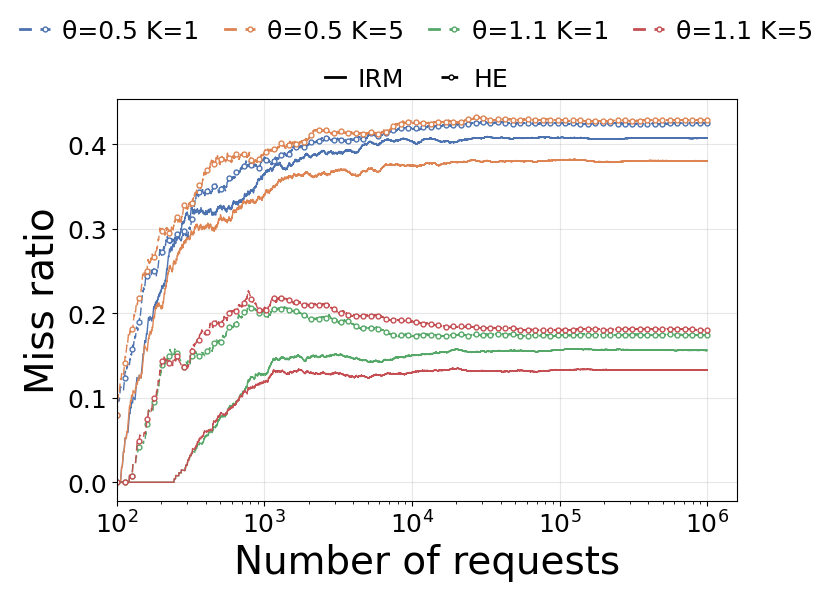

In [49]:
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

C = 60
thetas = [0.5, 1.1]
Ks = [1, 5]
N_ITEMS = 120
TRACE_LEN = 1000000
X_MIN = 100
HE_DASH = (0, (6, 3))
MARKERS_PER_LINE = 80

palette = sns.color_palette("deep", len(thetas) * len(Ks))
color_map = {(theta, K): palette[i] for i, (theta, K) in enumerate((t, k) for t in thetas for k in Ks)}

def run_curve(trace, K):
    rc = tg.ran_clock(C=C, K=K)
    _, _, examined, misses = rc.run_age(trace)
    misses = np.cumsum(misses)
    xs = np.arange(1, len(trace) + 1)
    hr = misses / xs
    mask = xs >= X_MIN
    return xs[mask], hr[mask], np.asarray(examined)[mask]

fig, ax = plt.subplots(figsize=(8, 6))
handles = []

# IRM curves + legend handles
for theta in thetas:
    trace_irm = gen_from_zipf(N_ITEMS, TRACE_LEN, theta)[1].astype(np.int32)
    for K in Ks:
        xs, hr, _ = run_curve(trace_irm, K)
        ax.plot(xs, hr, lw=1.0, linestyle="-", color=color_map[(theta, K)], label=None)
        solid = Line2D([], [], color=color_map[(theta, K)], linestyle="-", lw=2.0)
        dotted_he = Line2D([], [], color=color_map[(theta, K)], linestyle=HE_DASH, lw=2.0, marker="o", markersize=3.5, markerfacecolor="white", markeredgewidth=1.0)
        dotted_ph = Line2D([], [], color=color_map[(theta, K)], linestyle=HE_DASH, lw=2.0, marker="+", markersize=3.5, markerfacecolor="white", markeredgewidth=1.0)
        handles.append((solid, dotted_he, dotted_ph))

# PH curves
for theta in thetas:
    trace_ph = gen_ph_2class(N_ITEMS, theta, TRACE_LEN, mu_ratio=10.0).astype(np.int32)
    for K in Ks:
        xs, hr, _ = run_curve(trace_ph, K)
        mark_count = min(len(xs), MARKERS_PER_LINE)
        if len(xs) > 1:
            log_positions = np.geomspace(xs[0], xs[-1], num=mark_count)
            mark_indices = np.unique(np.searchsorted(xs, log_positions).clip(0, len(xs) - 1))
        else:
            mark_indices = np.array([0])
        ax.plot(xs, hr, lw=1.0, linestyle=HE_DASH, color=color_map[(theta, K)], label=None,
                marker="+", markersize=3.5, markerfacecolor="white", markeredgewidth=1.0,
                markevery=mark_indices)

# HE curves
for theta in thetas:
    trace_he = gen_ph(N_ITEMS, theta, TRACE_LEN).astype(np.int32)
    for K in Ks:
        xs, hr, _ = run_curve(trace_he, K)
        mark_count = min(len(xs), MARKERS_PER_LINE)
        if len(xs) > 1:
            log_positions = np.geomspace(xs[0], xs[-1], num=mark_count)
            mark_indices = np.unique(np.searchsorted(xs, log_positions).clip(0, len(xs) - 1))
        else:
            mark_indices = np.array([0])
        ax.plot(xs, hr, lw=1.0, linestyle=HE_DASH, color=color_map[(theta, K)], label=None,
                marker="o", markersize=3.5, markerfacecolor="white", markeredgewidth=1.0,
                markevery=mark_indices)

ax.tick_params(axis="both", labelsize=18)
ax.set_xlabel("Number of requests", fontsize=28)
ax.set_ylabel("Miss ratio", fontsize=28)
ax.set_xscale("log")
ax.set_xlim(left=X_MIN)
ax.grid(True, alpha=0.3)

labels = [f"θ={theta} K={K}" for theta in thetas for K in Ks]
style_handles = [
    Line2D([], [], color="black", linestyle="-", lw=2.0),
    Line2D([], [], color="black", linestyle=HE_DASH, lw=2.0, marker="o", markersize=3.5, markerfacecolor="white", markeredgewidth=1.0),
    Line2D([], [], color="black", linestyle=HE_DASH, lw=2.0, marker="+", markersize=3.5, markerfacecolor="white", markeredgewidth=1.0),
]

ncol_param = len(labels)

fig.legend(handles=handles, labels=labels,
           handler_map={tuple: HandlerTuple(ndivide=None)},
           loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=ncol_param,
           fontsize=18, frameon=False, handlelength=1.2, handletextpad=0.5, columnspacing=1.0)

fig.legend(handles=style_handles, labels=["IRM", "HE", "PH"],
           loc="upper center", bbox_to_anchor=(0.5, 0.87), ncol=3,
           fontsize=18, frameon=False, handlelength=0.8, handletextpad=0.5, columnspacing=1.5)

fig.subplots_adjust(top=0.78)

plt.savefig("ttf.pdf", bbox_inches="tight", format="pdf")
plt.show()


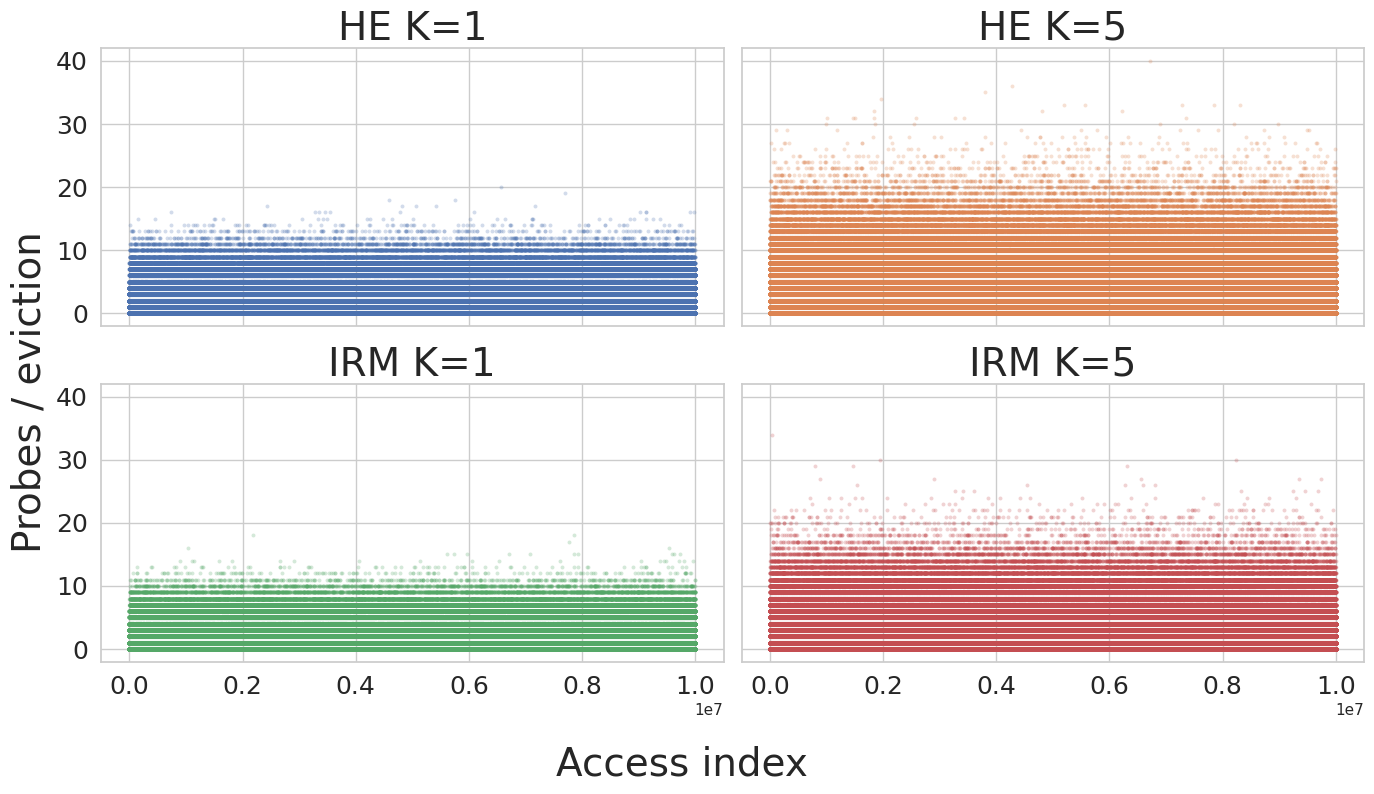

In [17]:

sns.set_theme(style="whitegrid", palette="deep")

rc1 = tg.ran_clock(C=60, K=1)
rc5 = tg.ran_clock(C=60, K=5)
_, _, examined_he1, _ = rc1.run_age(ph2)
_, _, examined_he, _ = rc5.run_age(ph2)
_, _, examined_irm1, _ = rc1.run_age(irm2)
_, _, examined_irm, _ = rc5.run_age(irm2)

def plot_probe_series(ax, probes, title, color, window=2000):
    probes = np.asarray(probes)
    idx = np.arange(probes.size)
    ev_mask = probes > 0

    ax.scatter(idx, probes, s=8, color=color, alpha=0.25, linewidths=0)

    med = pd.Series(probes).rolling(window, min_periods=max(50, window // 20)).median()
    ax.plot(idx, med, color=color, lw=2.5)

    rate = pd.Series(ev_mask, dtype=float).rolling(window, min_periods=1).mean()
    ax.fill_between(idx, 0, rate * probes.max(), color=color, alpha=0.08, step="mid")

    ax.set_title(title, fontsize=28)
    ax.tick_params(axis="both", labelsize=18)

series = [
    ("HE K=1", examined_he1),
    ("HE K=5", examined_he),
    ("IRM K=1", examined_irm1),
    ("IRM K=5", examined_irm),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
for ax, (title, arr), color in zip(axes.flat, series, palette):
    plot_probe_series(ax, arr, title, color)

fig.supxlabel("Access index", fontsize=28)
fig.supylabel("Probes / eviction", fontsize=28)
plt.tight_layout()
plt.savefig("probe_series.pdf", bbox_inches='tight')
plt.show()

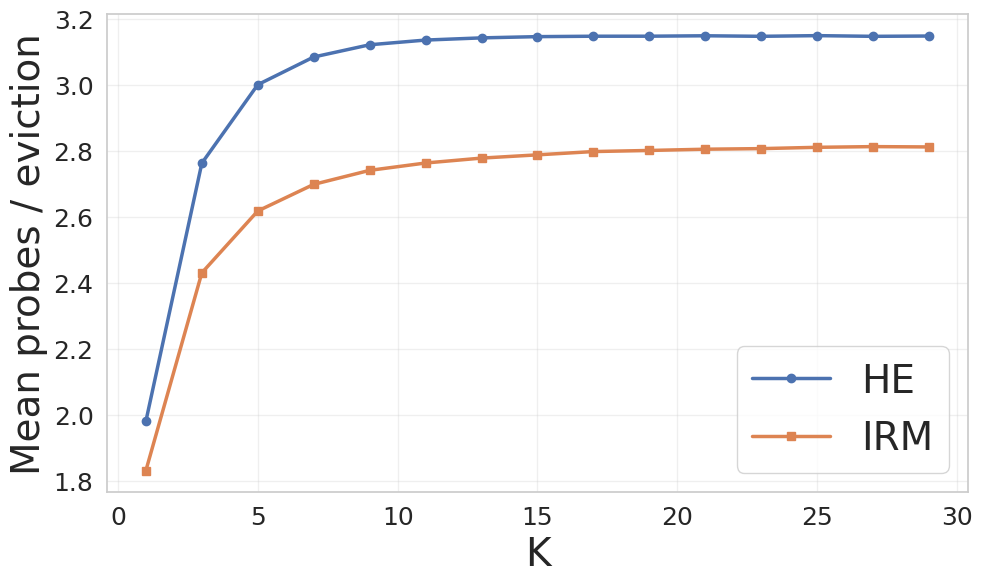

In [18]:
sns.set_theme(style="whitegrid", palette="deep")

ks = np.arange(1, 30, 2, dtype=int)
mean_he = np.empty_like(ks, dtype=float)
mean_irm = np.empty_like(ks, dtype=float)

for i, k in enumerate(ks):
    rc = tg.ran_clock(C=60, K=k)
    _, _, examined_he_k, _ = rc.run_age(ph2)
    _, _, examined_irm_k, _ = rc.run_age(irm2)

    arr_he = np.asarray(examined_he_k, dtype=float)
    arr_irm = np.asarray(examined_irm_k, dtype=float)
    nz_he = arr_he > 0
    nz_irm = arr_irm > 0

    mean_he[i] = arr_he[nz_he].mean() if nz_he.any() else 0.0
    mean_irm[i] = arr_irm[nz_irm].mean() if nz_irm.any() else 0.0

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ks, mean_he, marker='o', lw=2.5, label='HE')
ax.plot(ks, mean_irm, marker='s', lw=2.5, label='IRM')
ax.set_xlabel("K", fontsize=28)
ax.set_ylabel("Mean probes / eviction", fontsize=28)
ax.tick_params(axis="both", labelsize=18)
ax.legend(fontsize=28)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("mean_probes.pdf", bbox_inches="tight")
plt.show()



In [19]:
examined_he1[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 3, 0, 2, 0, 0, 2, 1, 1, 0], dtype=int32)

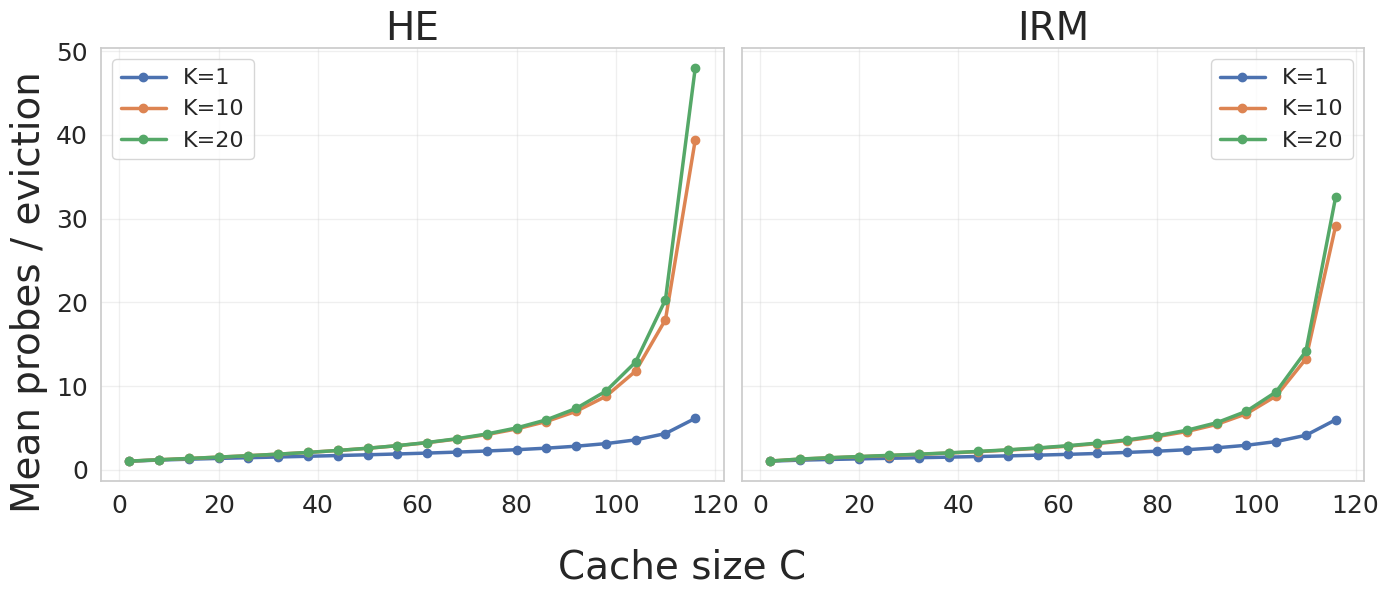

In [19]:
sns.set_theme(style="whitegrid", palette="deep")

k_values = [1, 10, 20]
Cs = np.arange(2, 121, 6)

means_he = np.zeros((len(k_values), len(Cs)), dtype=float)
means_irm = np.zeros_like(means_he)

for ki, k in enumerate(k_values):
    for ci, c in enumerate(Cs):
        rc = tg.ran_clock(C=c, K=k)
        _, _, examined_he_k, _ = rc.run_age(ph2)
        _, _, examined_irm_k, _ = rc.run_age(irm2)

        arr_he = np.asarray(examined_he_k)
        arr_irm = np.asarray(examined_irm_k)
        nz_he = arr_he > 0
        nz_irm = arr_irm > 0

        means_he[ki, ci] = arr_he[nz_he].mean() if nz_he.any() else 0.0
        means_irm[ki, ci] = arr_irm[nz_irm].mean() if nz_irm.any() else 0.0

palette = sns.color_palette("deep", len(k_values))
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, means, title in [
    (axes[0], means_he, r"HE"),
    (axes[1], means_irm, r"IRM"),
]:
    for k, color, vals in zip(k_values, palette, means):
        ax.plot(Cs, vals, marker="o", lw=2.5, color=color, label=f"K={k}")
    ax.set_title(title, fontsize=28)
    ax.tick_params(axis="both", labelsize=18)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=16)

fig.supxlabel("Cache size C", fontsize=28)
fig.supylabel("Mean probes / eviction", fontsize=28)
plt.tight_layout()
plt.savefig("probe_vs_C.pdf", bbox_inches="tight")
plt.show()

